# This notebook tests ANP-RNN + MC Dropout 

Ideally a NP should learn uncertainty, but it may also be overconfident. In neural network monte carlo dropout often provides a more robust uncertainty. Here I compare it and find that the uncertainty from MCLoss improved the validation loss when added to the models estimation of uncertainty.

In [1]:
import sys, re, os, itertools, functools, collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
from pathlib import Path
from tqdm.auto import tqdm

import optuna
import pytorch_lightning as pl
from optuna.integration import PyTorchLightningPruningCallback


import math
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger("RANP.ipynb")

In [3]:
import torch
from torch import nn
import torch.nn.functional as F

In [4]:
from src.models.model import LatentModel
from src.data.smart_meter import collate_fns, SmartMeterDataSet, get_smartmeter_df
from src.plot import plot_from_loader
from src.models.lightning_anp import LatentModelPL
from src.dict_logger import DictLogger

In [5]:
# Params
device='cuda'
use_logy=False

# Load kaggle smart meter data

In [6]:
df_train, df_test = get_smartmeter_df()

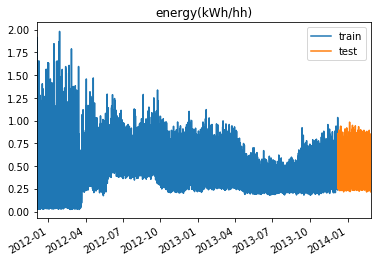

In [7]:
# Show split
df_train['energy(kWh/hh)'].plot(label='train')
df_test['energy(kWh/hh)'].plot(label='test')
plt.title('energy(kWh/hh)')
plt.legend()

# Train helpers

In [8]:
PERCENT_TEST_EXAMPLES = 0.5
# EPOCHS = 5
DIR = Path(os.getcwd())
MODEL_DIR = DIR/ 'optuna_result'/ 'anp-rnn-mcdropout'
name = 'anp-rnn-mcdropout' # study name
MODEL_DIR.mkdir(parents=True, exist_ok=True)
print(f"now run `tensorboard --logdir {MODEL_DIR}")

now run `tensorboard --logdir /media/wassname/Storage5/projects2/3ST/attentive-neural-processes/optuna_result/anp-rnn-mcdropout


In [9]:
def main(trial, train=True):    
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        os.path.join(MODEL_DIR, name, 'version_{}'.format(trial.number), "chk"), monitor='val_loss', mode="min")

    # The default logger in PyTorch Lightning writes to event files to be consumed by
    # TensorBoard. We create a simple logger instead that holds the log in memory so that the
    # final accuracy can be obtained after optimization. When using the default logger, the
    # final accuracy could be stored in an attribute of the `Trainer` instead.
    logger = DictLogger(MODEL_DIR, name="anp-rnn", version=trial.number)

    trainer = pl.Trainer(
        logger=logger,
        val_percent_check=PERCENT_TEST_EXAMPLES,
        gradient_clip_val=trial.params["grad_clip"],
        checkpoint_callback=checkpoint_callback,
        max_epochs=trial.params['max_nb_epochs'],
        gpus=-1 if torch.cuda.is_available() else None,
        early_stop_callback=PyTorchLightningPruningCallback(trial, monitor='val_loss')
    )
    model = LatentModelPL(trial.params)
    if train:
        trainer.fit(model)
    
    return model, trainer


def add_sugg(trial):
    
    trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)

    trial.suggest_categorical("hidden_dim", [8*2**i for i in range(6)])
    trial.suggest_categorical("latent_dim", [8*2**i for i in range(6)])
    
    trial.suggest_int("attention_layers", 1, 4)
    trial.suggest_categorical("n_latent_encoder_layers", [1, 2, 4, 8])
    trial.suggest_categorical("n_det_encoder_layers", [1, 2, 4, 8])
    trial.suggest_categorical("n_decoder_layers", [1, 2, 4, 8])

    trial.suggest_categorical("dropout", [0, 0.2, 0.5])
    trial.suggest_categorical("attention_dropout", [0, 0.2, 0.5])

    trial.suggest_categorical(
        "latent_enc_self_attn_type", ['uniform', 'multihead', 'ptmultihead']
    )
    trial.suggest_categorical("det_enc_self_attn_type",  ['uniform', 'multihead', 'ptmultihead'])
    trial.suggest_categorical("det_enc_cross_attn_type", ['uniform', 'multihead', 'ptmultihead'])

    trial.suggest_categorical("batchnorm", [False, True])
    trial.suggest_categorical("use_self_attn", [False, True])
    trial.suggest_categorical("use_lvar", [False, True])
    trial.suggest_categorical("use_deterministic_path", [False, True])
    trial.suggest_categorical("use_rnn", [True, False])

    # training specific (for this model)
    trial.suggest_uniform("min_std", 0.005, 0.005)
    trial.suggest_int("grad_clip", 40, 40)
    trial.suggest_int("num_context", 24 * 4, 24 * 4)
    trial.suggest_int("num_extra_target", 24*4, 24*4)
    trial.suggest_int("max_nb_epochs", 10, 50)
    trial.suggest_int("num_workers", 3, 3)
    trial.suggest_int("batch_size", 16, 16)
    trial.suggest_int("num_heads", 8, 8)

    trial.suggest_int("x_dim", 17, 17)
    trial.suggest_int("y_dim", 1, 1)
    trial.suggest_int("vis_i", 670, 670)
    
    trial.suggest_categorical("context_in_target", [True, True])
    
    return trial

def objective(trial):
    # see https://github.com/optuna/optuna/blob/cf6f02d/examples/pytorch_lightning_simple.py
    
    trial = add_sugg(trial)
    
    print('trial', trial.number, 'params', trial.params)
    
    
    # PyTorch Lightning will try to restore model parameters from previous trials if checkpoint
    # filenames match. Therefore, the filenames for each trial must be made unique.
    model, trainer = main(trial)
    
    # also report to tensorboard & print
    print('logger.metrics', model.logger.metrics[-1:])
    model.logger.experiment.add_hparams(trial.params, model.logger.metrics[-1])
    
    return model.logger.metrics[-1]['val_loss']


[8, 16, 32, 64, 128, 256]

# Default params

In [10]:
default_params = {
 'attention_dropout': 0,
 'attention_layers': 2,
 'batch_size': 16,
 'batchnorm': False,
 'det_enc_cross_attn_type': 'multihead',
 'det_enc_self_attn_type': 'uniform',
 'dropout': 0,
 'grad_clip': 40,
 'hidden_dim': 128,
 'latent_dim': 128,
 'latent_enc_self_attn_type': 'uniform',
 'learning_rate': 0.002,
 'max_nb_epochs': 10,
 'min_std': 0.005,
 'n_decoder_layers': 4,
 'n_det_encoder_layers': 4,
 'n_latent_encoder_layers': 4,
 'num_context': 24*4,
 'num_extra_target': 24*4,
 'num_heads': 8,
 'num_workers': 3,
 'use_deterministic_path': True,
 'use_lvar': True,
 'use_self_attn': True,
 'vis_i': '670',
 'x_dim': 17,
 'y_dim': 1,
 'use_rnn': False,
 'context_in_target': True
}

# Train ANP-RNN

# ANP-RNN 2

INFO:root:gpu available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
                                  Name           Type Params
0                                model    LatentModel  240 K
1                          model._lstm           LSTM   54 K
2                model._latent_encoder  LatentEncoder   18 K
3   model._latent_encoder._input_layer         Linear    4 K
4       model._latent_encoder._encoder     ModuleList    8 K
..                                 ...            ...    ...
61       model._decoder._decoder.1.act           ReLU    0  
62   model._decoder._decoder.1.dropout      Dropout2d    0  
63      model._decoder._decoder.1.norm    BatchNorm2d  160  
64                model._decoder._mean         Linear   81  
65                 model._decoder._std         Linear   81  

[66 rows x 3 columns]


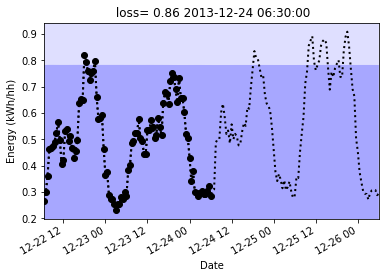

step 0, {'val_loss': '0.8263072967529297', 'val/kl': '9.426824476577167e-07', 'val/mse': '0.23334717750549316', 'val/std': '0.7340755462646484'}


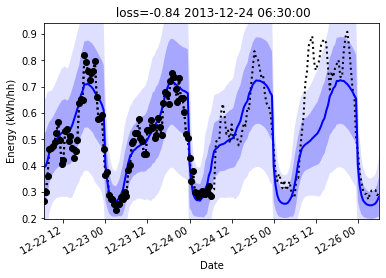

step 2194, {'val_loss': '-1.106635570526123', 'val/kl': '0.00035303342156112194', 'val/mse': '0.006762748118489981', 'val/std': '0.10881799459457397'}


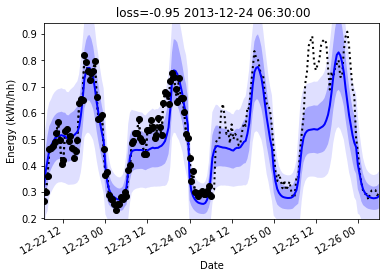

step 4389, {'val_loss': '-1.2668572664260864', 'val/kl': '0.00018746273417491466', 'val/mse': '0.006942092906683683', 'val/std': '0.07408321648836136'}


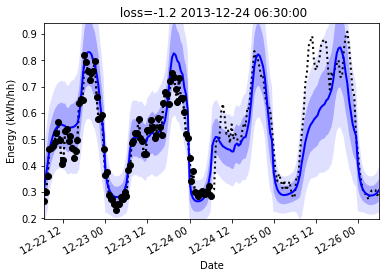

step 6584, {'val_loss': '-1.3773473501205444', 'val/kl': '0.0005628759390674531', 'val/mse': '0.004523121751844883', 'val/std': '0.0694846659898758'}


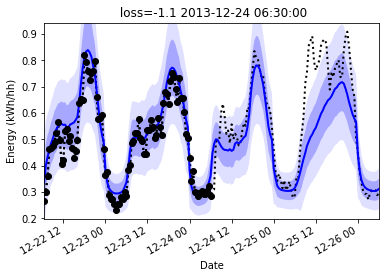

step 8779, {'val_loss': '-1.3312143087387085', 'val/kl': '0.00040610754513181746', 'val/mse': '0.0049763941206038', 'val/std': '0.06839941442012787'}


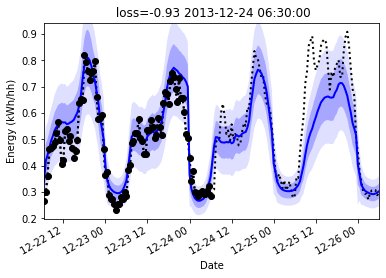

step 10974, {'val_loss': '-1.3481171131134033', 'val/kl': '0.0004090859729330987', 'val/mse': '0.004730559419840574', 'val/std': '0.058878093957901'}


KeyboardInterrupt: 

In [16]:
name = 'anp-rnn-mcdropout'

params =default_params.copy()
params.update({
 'det_enc_cross_attn_type': 'ptmultihead',
 'det_enc_self_attn_type': 'uniform',
 'latent_enc_self_attn_type': 'uniform',
 'learning_rate': 1e-3,
 'max_nb_epochs': 40,
 'dropout': 0.2,
 'hidden_dim': 64,
 'latent_dim': 16,
 'n_decoder_layers': 2,
 'n_det_encoder_layers': 2,
 'n_latent_encoder_layers': 2,
 'use_deterministic_path': False,
 'use_lvar': False,
 'use_rnn': True,
 'batchnorm': True
    
})
trial = optuna.trial.FixedTrial(params)
trial._user_attrs = {
        'batch_size': 16,
        'grad_clip': 40,
        'max_nb_epochs': 200,
        'num_workers': 4,
        'target_length': 24,
        'vis_i': 670,
        'window_length': 48,
        'input_size': x.shape[-1],
        'output_size': y.shape[-1]
}
trial = add_sugg(trial)
trial.number = 47

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    os.path.join(MODEL_DIR, name, 'version_{}'.format(trial.number), "chk"), monitor='val_loss', mode="min")

logger = DictLogger(MODEL_DIR, name="anp", version=trial.number)

trainer = pl.Trainer(
    gradient_clip_val=trial.params["grad_clip"],
    checkpoint_callback=checkpoint_callback,
    max_epochs=trial.params['max_nb_epochs'],
    gpus=-1 if torch.cuda.is_available() else None,
    early_stop_callback=True
)
model = LatentModelPL(dict(**trial.params, **trial.user_attrs))

trainer.fit(model)

# plot, main metric
loader = model.val_dataloader()[0]
vis_i=670
plot_from_loader(loader, model, i=vis_i)

print(trainer.test(model))

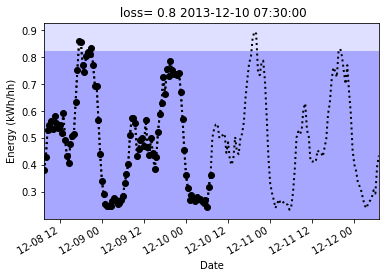

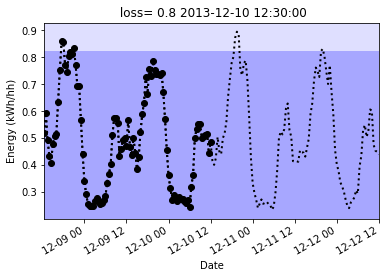

KeyboardInterrupt: 

In [15]:
# plot lots of metrics
loader = model.val_dataloader()[0]
for i in range(0, len(loader), 10):
    plot_from_loader(loader, model, i=i)
    plt.show()

# MCDropout test

https://towardsdatascience.com/bayesian-deep-learning-with-fastai-how-not-to-be-uncertain-about-your-uncertainty-6a99d1aa686e

We will apply mcdropout by:
- replacing dropout with a class that will still be on during test
- doing multiple inference

In [ ]:
from typing import Callable

def convert_layers(model:nn.Module, original:nn.Module, value: bool):
    """
    Turn dropout on
    """
    for child_name, child in model.named_children():
        if isinstance(child, original):
#             print(child, 'from', child.training, 'to', value)
            child.train(value)
            
        else:
            convert_layers(child, original, value)

In [ ]:
from src.plot import plot_rows
loader = model.val_dataloader()[0]
device = next(model.parameters()).device

# Get data
i = 670
data = loader.collate_fn([loader.dataset[i]], sample=False)
data = [d.to(device) for d in data]
context_x, context_y, target_x_extra, target_y_extra = data
target_x = target_x_extra
target_y = target_y_extra

# for plotting
x_rows, y_rows = loader.dataset.get_rows(i)
max_num_context = context_x.shape[1]
y_context_rows = y_rows[:max_num_context]
y_target_extra_rows = y_rows[max_num_context:]
dt = y_target_extra_rows.index[0]
y_target_rows = y_rows

In [ ]:
# do MCDropout estimation
model.eval()
convert_layers(model, torch.nn.modules.dropout.Dropout2d, True)
model.model._lstm.train()

y_preds = []
y_stds = []
with torch.no_grad():
    for i in range(10):
        y_pred, kl, loss_test, loss_mse, y_std = model(context_x, context_y, target_x, target_y)
        y_preds.append(y_pred.cpu().numpy())
        y_stds.append(y_std.cpu().numpy())

y_stds = np.stack(y_stds)
y_preds = np.stack(y_preds)


In [ ]:
# Lets add variation to std, since it it's unsure.. std should be higher. Although this is small
# When it's unsure of the mean, we will also add that, this is large
# This is just a quick and dirty uncalibrated one sure, we could use
y_std = y_stds.mean(0) + y_stds.std(0) + y_preds.std(0)
y_std = y_preds.std(0)
print(f'predicted std {y_stds.mean():2.2f} \nstd of std {y_stds.std(0).mean():2.2f} \nmcdropout of mean {y_preds.std(0).mean():2.2f}')
y_pred = y_preds.mean(0)

In [ ]:
# with 3 sources of uncertainrty: model output and std of mean
y_std = y_stds.mean(0) + y_preds.std(0)
plot_rows(
    y_target_rows,
    y_context_rows,
    y_pred,
    y_std,
    legend=False
)
plt.show()

In [ ]:
# Try without MCDropout
model.eval()
with torch.no_grad():
    y_pred, kl, loss_test, loss_mse, y_std = model(context_x, context_y, target_x, target_y)

plot_rows(
    y_target_rows,
    y_context_rows,
    y_pred.detach().cpu().numpy(),
    y_std.detach().cpu().numpy(),
)
plt.show()

## Full test

In [ ]:
from src.plot import plot_rows

In [ ]:


def eval_mc(model, loader, i):
    loader = model.val_dataloader()[0]
    device = next(model.parameters()).device

    data = loader.collate_fn([loader.dataset[i]], sample=False)
    data = [d.to(device) for d in data]
    context_x, context_y, target_x_extra, target_y_extra = data
    target_x = target_x_extra
    target_y = target_y_extra

    # do MCDropout estimation
    model.eval()
    convert_layers(model, torch.nn.modules.dropout.Dropout2d, True)
    model.model._lstm.train()

    y_preds = []
    y_stds = []
    with torch.no_grad():
        for i in range(n_mcdropout):
            y_pred, kl, loss_test, loss_mse, y_std = model(context_x, context_y, target_x, target_y)
            y_preds.append(y_pred)
            y_stds.append(y_std)
    y_stds = torch.stack(y_stds)
    y_preds = torch.stack(y_preds)


    mean = y_preds.mean(0)
    sigma = y_stds.mean(0)

    dist = torch.distributions.Normal(mean, sigma)
    log_p = dist.log_prob(target_y).mean(-1)
    loss_mc = - log_p


    # Try without MCDropout
    model.eval()
    with torch.no_grad():
        y_pred, kl, loss_test, loss_mse, y_std = model(context_x, context_y, target_x, target_y)

    dist = torch.distributions.Normal(y_pred, y_std)
    log_p = dist.log_prob(target_y).mean(-1)
    loss = - log_p   

    return loss_mc.cpu(), loss.cpu()

In [ ]:
n_mcdropout=10
n_steps=300

In [ ]:
# Get data
inds = np.random.randint(0, len(loader.dataset), n_steps)

losses_mc = []
losses = []
for i in tqdm(inds):
    loss_mc, loss = eval_mc(model, loader, i)
    losses_mc.append(loss_mc)
    losses.append(loss)
    

In [ ]:
loss_mc = torch.stack(losses_mc).mean()
loss = torch.stack(losses).mean()
print(f"Lower is better, validation loss")
print(f"MCDropout: {loss_mc:2.2f}")
print(f"Inference: {loss:2.2f}")

We can see that we get a better (lower) loss when we not only use the models estimate of the loss, but we take a step back and add an estimate of how unsure the model behaves. 

There are remaining sources of uncertainty that are not reflected in how the model behaviour varies with dropout.
